# E-commerce Text Classification: Hyperparameter Tuning

**Цель:** Оптимизировать гиперпараметры лучших моделей из предыдущих ноутбуков для максимального улучшения качества классификации.

**Модели для тюнинга:**
1. Logistic Regression + TF-IDF (для продакшена)
2. Linear SVM (лучшая baseline модель)
3. LightGBM (быстрый градиентный бустинг)
4. DistilBERT Fine-Tuning (максимальное качество, ≤1 часа)

**Методы поиска:**
- GridSearchCV — полный перебор для малых пространств
- RandomizedSearchCV — случайный поиск для больших пространств
- Optuna (опционально) — байесовская оптимизация

## 1. Импорт библиотек

In [22]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import pickle
import json
import os
import subprocess
warnings.filterwarnings('ignore')

# Progress bar
from tqdm.notebook import tqdm

# sklearn
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV, 
    StratifiedKFold, 
    cross_val_score,
    train_test_split
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, randint, loguniform

# LightGBM
import lightgbm as lgb

# Transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from datasets import Dataset
import torch

# Модули проекта
import sys
sys.path.append('..')
from src.data_loader import load_data, preprocess_data, split_data

# Настройка стилей
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Загрузка и подготовка данных

In [23]:
# Загрузка данных
df = load_data('../data/ecommerceDataset.csv')

print(f'Размер датасета: {df.shape[0]} строк')
print(f'Классы: {df["category"].unique()}')
print(f'Распределение классов:\n{df["category"].value_counts()}')

Размер датасета: 50425 строк
Классы: <ArrowStringArray>
['Household', 'Books', 'Clothing & Accessories', 'Electronics']
Length: 4, dtype: str
Распределение классов:
category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


In [24]:
# Разбиение на train/test (стратифицированное)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = split_data(
    df['description'],
    df['category'],
    test_size=0.2,
    random_state=42
)

# Предобработка
train_df = preprocess_data(pd.DataFrame({'description': X_train_raw, 'category': y_train_raw}))
test_df = preprocess_data(pd.DataFrame({'description': X_test_raw, 'category': y_test_raw}))

X_train = train_df['description']
y_train = train_df['category']
X_test = test_df['description']
y_test = test_df['category']

print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 24574, Test: 8697


## 3. Тюнинг Logistic Regression + TF-IDF

In [25]:
# Определение пайплайна
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
])

# Параметры для поиска (сокращённое пространство для скорости)
param_grid_lr = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 2],
    'clf__C': [0.5, 1.0, 5.0]
}

# Стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV для скорости
print('Запуск тюнинга Logistic Regression...')
start_time = time.time()

lr_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=15,  # 15 комбинаций
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lr_search.fit(X_train, y_train)

lr_time = time.time() - start_time
print(f'\nВремя тюнинга: {lr_time:.1f} сек ({lr_time/60:.1f} мин)')
print(f'Лучший F1-macro (CV): {lr_search.best_score_:.4f}')
print(f'Лучшие параметры: {lr_search.best_params_}')

Запуск тюнинга Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Время тюнинга: 105.3 сек (1.8 мин)
Лучший F1-macro (CV): 0.9510
Лучшие параметры: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1, 'tfidf__max_features': 10000, 'clf__C': 5.0}


In [26]:
# Оценка на тесте
y_pred_lr = lr_search.predict(X_test)
f1_lr_test = f1_score(y_test, y_pred_lr, average='macro')

print(f'Logistic Regression - F1-macro на тесте: {f1_lr_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression - F1-macro на тесте: 0.9717

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.97      0.96      0.97      2024
Clothing & Accessories       0.98      0.98      0.98      1551
           Electronics       0.97      0.95      0.96      1760
             Household       0.96      0.98      0.97      3362

              accuracy                           0.97      8697
             macro avg       0.97      0.97      0.97      8697
          weighted avg       0.97      0.97      0.97      8697



## 4. Тюнинг Linear SVM

In [27]:
# Пайплайн для SVM
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(max_iter=2000, random_state=42))
])

# Параметры для поиска
param_grid_svm = {
    'tfidf__max_features': [5000, 10000, 15000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 0.5, 1.0, 5.0, 10.0]
}

print('Запуск тюнинга Linear SVM...')
start_time = time.time()

svm_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    n_iter=20,  # 20 комбинаций
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

svm_search.fit(X_train, y_train)

svm_time = time.time() - start_time
print(f'\nВремя тюнинга: {svm_time:.1f} сек ({svm_time/60:.1f} мин)')
print(f'Лучший F1-macro (CV): {svm_search.best_score_:.4f}')
print(f'Лучшие параметры: {svm_search.best_params_}')

Запуск тюнинга Linear SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Время тюнинга: 117.6 сек (2.0 мин)
Лучший F1-macro (CV): 0.9572
Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 15000, 'clf__C': 1.0}


In [28]:
# Оценка на тесте
y_pred_svm = svm_search.predict(X_test)
f1_svm_test = f1_score(y_test, y_pred_svm, average='macro')

print(f'Linear SVM - F1-macro на тесте: {f1_svm_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm, zero_division=0))

Linear SVM - F1-macro на тесте: 0.9768

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.98      0.97      0.98      2024
Clothing & Accessories       0.98      0.98      0.98      1551
           Electronics       0.97      0.97      0.97      1760
             Household       0.97      0.98      0.98      3362

              accuracy                           0.98      8697
             macro avg       0.98      0.98      0.98      8697
          weighted avg       0.98      0.98      0.98      8697



## 5. Тюнинг LightGBM

In [29]:
# Векторизация для LightGBM
vectorizer_lgb = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_lgb = vectorizer_lgb.fit_transform(X_train)
X_test_lgb = vectorizer_lgb.transform(X_test)

# Параметры для поиска
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50],
    'min_child_samples': [10, 20]
}

start_time = time.time()

# Ручная кросс-валидация с tqdm progress bar
n_splits = 5
n_iter = 10
total_fits = n_splits * n_iter

best_score = 0
best_params = {}
best_model = None

# Progress bar для LightGBM CV
print(f'📊 Всего итераций: {n_iter}, всего фитов: {total_fits} ({n_splits} folds)')
print('='*60)

# Используем tqdm напрямую в цикле
for i in tqdm(range(n_iter), desc='LightGBM CV', unit='iter',
              bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]'):
    
    # Случайный выбор параметров
    params = {
        'n_estimators': int(np.random.choice(param_grid_lgb['n_estimators'])),
        'learning_rate': float(np.random.choice(param_grid_lgb['learning_rate'])),
        'max_depth': int(np.random.choice(param_grid_lgb['max_depth'])),
        'num_leaves': int(np.random.choice(param_grid_lgb['num_leaves'])),
        'min_child_samples': int(np.random.choice(param_grid_lgb['min_child_samples'])),
        'random_state': 42,
        'device': 'cpu',  
        'n_jobs': 4,
        'verbose': -1,
        'force_col_wise': True
    }
    
    # Создание модели с текущими параметрами
    lgb_temp = lgb.LGBMClassifier(**params)
    
    # Кросс-валидация
    scores = cross_val_score(lgb_temp, X_train_lgb, y_train, 
                            cv=n_splits, scoring='f1_macro', n_jobs=1)
    
    mean_score = scores.mean()
    
    # Обновление описания progress bar с текущим F1
    tqdm.write(f'Итерация {i+1}/{n_iter}: F1={mean_score:.4f} (±{scores.std():.4f})')
    
    # Сохранение лучшей модели
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = lgb_temp

    # Сохранение лучшей модели
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Финальное обучение модели на всех данных
print(f'\n🎯 Лучшие параметры: {best_params}')
print('Обучение финальной модели...')

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_lgb, y_train)

lgb_time = time.time() - start_time

# Сохранение результатов
lgb_search = type('obj', (object,), {
    'best_score_': best_score,
    'best_params_': best_params,
    'best_estimator_': final_model,
    'cv_results_': {}
})()

print(f'⏱️ Время тюнинга LightGBM: {lgb_time:.1f} сек ({lgb_time/60:.1f} мин)')


📊 Всего итераций: 10, всего фитов: 50 (5 folds)


LightGBM CV:   0%|          | 0/10 [00:00<?, ?iter/s]

Итерация 1/10: F1=0.8889 (±0.0083)
Итерация 2/10: F1=0.8424 (±0.0082)
Итерация 3/10: F1=0.9395 (±0.0059)
Итерация 4/10: F1=0.9116 (±0.0078)
Итерация 5/10: F1=0.9170 (±0.0087)
Итерация 6/10: F1=0.7911 (±0.0116)
Итерация 7/10: F1=0.8426 (±0.0080)
Итерация 8/10: F1=0.9303 (±0.0071)
Итерация 9/10: F1=0.9344 (±0.0065)
Итерация 10/10: F1=0.8996 (±0.0080)

🎯 Лучшие параметры: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'min_child_samples': 10, 'random_state': 42, 'device': 'cpu', 'n_jobs': 4, 'verbose': -1, 'force_col_wise': True}
Обучение финальной модели...
⏱️ Время тюнинга LightGBM: 1542.0 сек (25.7 мин)


In [30]:
# Оценка на тесте
y_pred_lgb = lgb_search.best_estimator_.predict(X_test_lgb)
f1_lgb_test = f1_score(y_test, y_pred_lgb, average='macro')

print(f'LightGBM - F1-macro на тесте: {f1_lgb_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lgb, zero_division=0))

LightGBM - F1-macro на тесте: 0.9709

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.97      0.97      0.97      2024
Clothing & Accessories       0.98      0.98      0.98      1551
           Electronics       0.98      0.95      0.96      1760
             Household       0.96      0.98      0.97      3362

              accuracy                           0.97      8697
             macro avg       0.97      0.97      0.97      8697
          weighted avg       0.97      0.97      0.97      8697



## 6. Тюнинг DistilBERT Fine-Tuning

In [31]:
# Кодирование меток
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Разделение train на train/val для честной валидации (80/20)
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    X_train, y_train_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_train_encoded
)

print(f'Train (для BERT): {len(X_train_bert)}')
print(f'Validation: {len(X_val_bert)}')
print(f'Test: {len(X_test)}')

# Токенизация (кэшируем для скорости)
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print('\nТокенизация данных...')
max_length = 256  # Увеличено для сохранения информации  # Уменьшено для скорости

def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

X_train_tokenized = tokenize_function(X_train_bert)
X_val_tokenized = tokenize_function(X_val_bert)
X_test_tokenized = tokenize_function(X_test)

# Создание Dataset
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenized['input_ids'],
    'attention_mask': X_train_tokenized['attention_mask'],
    'labels': y_train_bert
})

val_dataset = Dataset.from_dict({
    'input_ids': X_val_tokenized['input_ids'],
    'attention_mask': X_val_tokenized['attention_mask'],
    'labels': y_val_bert
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenized['input_ids'],
    'attention_mask': X_test_tokenized['attention_mask'],
    'labels': y_test_encoded
})

print(f'\nРазмер train dataset: {len(train_dataset)}')
print(f'Размер val dataset: {len(val_dataset)}')
print(f'Размер test dataset: {len(test_dataset)}')

Train (для BERT): 19659
Validation: 4915
Test: 8697

Токенизация данных...

Размер train dataset: 19659
Размер val dataset: 4915
Размер test dataset: 8697


In [32]:
# Гиперпараметры для поиска 
bert_param_grid = [
    {
        'learning_rate': 2e-5,
        'batch_size': 16,
        'num_epochs': 2
    },
    {
        'learning_rate': 3e-5,
        'batch_size': 32,
        'num_epochs': 3
    },
    {
        'learning_rate': 5e-5,
        'batch_size': 64,
        'num_epochs': 3
    },
    {
        'learning_rate': 5e-5,
        'batch_size': 16,
        'num_epochs': 4
    },
    {
        'learning_rate': 5e-5,
        'batch_size': 32,
        'num_epochs': 4
    },
    {
        'learning_rate': 3e-5,
        'batch_size': 32,
        'num_epochs': 5
    }
]

print(f'Количество комбинаций для поиска: {len(bert_param_grid)} (ПОЛНЫЙ ПРОГОН)')
print(f'Ожидаемое время: ~30-40 минут')


Количество комбинаций для поиска: 6 (ПОЛНЫЙ ПРОГОН)
Ожидаемое время: ~30-40 минут


In [33]:
# Функция для обучения и оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'f1_macro': f1_score(labels, predictions, average='macro')}

# Тюнинг DistilBERT
bert_results = []
best_f1 = 0
best_f1_test = 0  # Test score
best_params = None
best_model = None

print('Запуск тюнинга DistilBERT...')
bert_start_time = time.time()

for i, params in enumerate(bert_param_grid):
    print(f'\n{"="*50}')
    print(f'Комбинация {i+1}/{len(bert_param_grid)}')
    print(f'Параметры: {params}')
    
    combo_start = time.time()
    
    # Загрузка модели
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(le.classes_)
    )
    
    # Параметры обучения
    training_args = TrainingArguments(
        output_dir=f'./results_bert_{i}',
        num_train_epochs=params['num_epochs'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'] * 2,
        learning_rate=params['learning_rate'],
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'./logs_bert_{i}',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        disable_tqdm=True,
        fp16=torch.cuda.is_available(),
        seed=42,
    )
    
    # Создание Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,  # Validation
        compute_metrics=compute_metrics
    )
    
    # Обучение
    trainer.train()
    
    # Оценка
    eval_results = trainer.evaluate(val_dataset)
    f1_bert_val = eval_results.get('eval_f1_macro', 0)
    
    combo_time = time.time() - combo_start
    
    print(f'F1-macro (Val): {f1_bert_val:.4f}')
    print(f'Время комбинации: {combo_time:.1f} сек ({combo_time/60:.1f} мин)')
    
    bert_results.append({
        'params': params,
        'f1_macro_val': f1_bert_val,
        'time': combo_time
    })
    
    if f1_bert_val > best_f1:
        best_f1 = f1_bert_val
        best_params = params
        best_model = trainer.model
    
    # Очистка памяти
    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

bert_total_time = time.time() - bert_start_time
print(f'\n{"="*50}')
print(f'Общее время тюнинга DistilBERT: {bert_total_time:.1f} сек ({bert_total_time/60:.1f} мин)')
print(f'Лучший F1-macro: {best_f1:.4f}')
print(f'Лучшие параметры: {best_params}')

Запуск тюнинга DistilBERT...

Комбинация 1/6
Параметры: {'learning_rate': 2e-05, 'batch_size': 16, 'num_epochs': 2}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '1.05', 'grad_norm': '6.401', 'learning_rate': '1.98e-05', 'epoch': '0.08137'}
{'loss': '0.3004', 'grad_norm': '4.776', 'learning_rate': '1.917e-05', 'epoch': '0.1627'}
{'loss': '0.1954', 'grad_norm': '2.008', 'learning_rate': '1.832e-05', 'epoch': '0.2441'}
{'loss': '0.2446', 'grad_norm': '1.944', 'learning_rate': '1.747e-05', 'epoch': '0.3255'}
{'loss': '0.2141', 'grad_norm': '0.3111', 'learning_rate': '1.662e-05', 'epoch': '0.4068'}
{'loss': '0.2028', 'grad_norm': '0.4217', 'learning_rate': '1.578e-05', 'epoch': '0.4882'}
{'loss': '0.2366', 'grad_norm': '9.99', 'learning_rate': '1.493e-05', 'epoch': '0.5696'}
{'loss': '0.207', 'grad_norm': '8.353', 'learning_rate': '1.408e-05', 'epoch': '0.6509'}
{'loss': '0.1689', 'grad_norm': '1.922', 'learning_rate': '1.323e-05', 'epoch': '0.7323'}
{'loss': '0.2035', 'grad_norm': '7.596', 'learning_rate': '1.238e-05', 'epoch': '0.8137'}
{'loss': '0.1857', 'grad_norm': '9.533', 'learning_rate': '1.154e-05', 'epoch': '0.895'}
{'loss': '0.1

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.147', 'grad_norm': '1.995', 'learning_rate': '9.839e-06', 'epoch': '1.058'}
{'loss': '0.1069', 'grad_norm': '10.31', 'learning_rate': '8.991e-06', 'epoch': '1.139'}
{'loss': '0.151', 'grad_norm': '18.39', 'learning_rate': '8.142e-06', 'epoch': '1.221'}
{'loss': '0.1113', 'grad_norm': '0.1933', 'learning_rate': '7.294e-06', 'epoch': '1.302'}
{'loss': '0.1307', 'grad_norm': '0.4865', 'learning_rate': '6.446e-06', 'epoch': '1.383'}
{'loss': '0.1708', 'grad_norm': '0.1908', 'learning_rate': '5.598e-06', 'epoch': '1.465'}
{'loss': '0.1585', 'grad_norm': '4.399', 'learning_rate': '4.75e-06', 'epoch': '1.546'}
{'loss': '0.1305', 'grad_norm': '0.2943', 'learning_rate': '3.902e-06', 'epoch': '1.627'}
{'loss': '0.1379', 'grad_norm': '3.339', 'learning_rate': '3.053e-06', 'epoch': '1.709'}
{'loss': '0.0969', 'grad_norm': '0.1103', 'learning_rate': '2.214e-06', 'epoch': '1.79'}
{'loss': '0.1807', 'grad_norm': '0.2242', 'learning_rate': '1.366e-06', 'epoch': '1.871'}
{'loss': '0.1053', 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '218.9', 'train_samples_per_second': '179.7', 'train_steps_per_second': '11.23', 'train_loss': '0.2074', 'epoch': '2'}
{'eval_loss': '0.1784', 'eval_f1_macro': '0.9563', 'eval_runtime': '6.515', 'eval_samples_per_second': '754.4', 'eval_steps_per_second': '23.64', 'epoch': '2'}
F1-macro (Val): 0.9563
Время комбинации: 226.7 сек (3.8 мин)

Комбинация 2/6
Параметры: {'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 3}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '0.8916', 'grad_norm': '3.505', 'learning_rate': '2.97e-05', 'epoch': '0.1626'}
{'loss': '0.2321', 'grad_norm': '6.345', 'learning_rate': '2.83e-05', 'epoch': '0.3252'}
{'loss': '0.2114', 'grad_norm': '2.496', 'learning_rate': '2.658e-05', 'epoch': '0.4878'}
{'loss': '0.2215', 'grad_norm': '3.506', 'learning_rate': '2.486e-05', 'epoch': '0.6504'}
{'loss': '0.1832', 'grad_norm': '2.346', 'learning_rate': '2.314e-05', 'epoch': '0.813'}
{'loss': '0.1898', 'grad_norm': '4.091', 'learning_rate': '2.142e-05', 'epoch': '0.9756'}
{'eval_loss': '0.167', 'eval_f1_macro': '0.9528', 'eval_runtime': '6.215', 'eval_samples_per_second': '790.9', 'eval_steps_per_second': '12.39', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1147', 'grad_norm': '3.307', 'learning_rate': '1.97e-05', 'epoch': '1.138'}
{'loss': '0.1185', 'grad_norm': '2.149', 'learning_rate': '1.798e-05', 'epoch': '1.301'}
{'loss': '0.1447', 'grad_norm': '8.227', 'learning_rate': '1.628e-05', 'epoch': '1.463'}
{'loss': '0.1417', 'grad_norm': '1.14', 'learning_rate': '1.456e-05', 'epoch': '1.626'}
{'loss': '0.1133', 'grad_norm': '4.134', 'learning_rate': '1.284e-05', 'epoch': '1.789'}
{'loss': '0.1352', 'grad_norm': '3.495', 'learning_rate': '1.112e-05', 'epoch': '1.951'}
{'eval_loss': '0.1638', 'eval_f1_macro': '0.96', 'eval_runtime': '6.221', 'eval_samples_per_second': '790', 'eval_steps_per_second': '12.38', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.09903', 'grad_norm': '2.026', 'learning_rate': '9.421e-06', 'epoch': '2.114'}
{'loss': '0.08433', 'grad_norm': '1.764', 'learning_rate': '7.702e-06', 'epoch': '2.276'}
{'loss': '0.06506', 'grad_norm': '0.1642', 'learning_rate': '5.983e-06', 'epoch': '2.439'}
{'loss': '0.08762', 'grad_norm': '1.485', 'learning_rate': '4.264e-06', 'epoch': '2.602'}
{'loss': '0.07969', 'grad_norm': '0.1349', 'learning_rate': '2.544e-06', 'epoch': '2.764'}
{'loss': '0.06003', 'grad_norm': '2.378', 'learning_rate': '8.252e-07', 'epoch': '2.927'}
{'eval_loss': '0.1599', 'eval_f1_macro': '0.9585', 'eval_runtime': '6.254', 'eval_samples_per_second': '786', 'eval_steps_per_second': '12.31', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '282.2', 'train_samples_per_second': '209', 'train_steps_per_second': '6.538', 'train_loss': '0.1745', 'epoch': '3'}
{'eval_loss': '0.1638', 'eval_f1_macro': '0.96', 'eval_runtime': '6.236', 'eval_samples_per_second': '788.2', 'eval_steps_per_second': '12.35', 'epoch': '3'}
F1-macro (Val): 0.9600
Время комбинации: 289.6 сек (4.8 мин)

Комбинация 3/6
Параметры: {'learning_rate': 5e-05, 'batch_size': 64, 'num_epochs': 3}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '0.7217', 'grad_norm': '3.583', 'learning_rate': '4.95e-05', 'epoch': '0.3247'}
{'loss': '0.2216', 'grad_norm': '2.083', 'learning_rate': '4.399e-05', 'epoch': '0.6494'}
{'loss': '0.1898', 'grad_norm': '3.159', 'learning_rate': '3.792e-05', 'epoch': '0.974'}
{'eval_loss': '0.1759', 'eval_f1_macro': '0.9504', 'eval_runtime': '6.13', 'eval_samples_per_second': '801.9', 'eval_steps_per_second': '6.363', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1279', 'grad_norm': '2.979', 'learning_rate': '3.186e-05', 'epoch': '1.299'}
{'loss': '0.1487', 'grad_norm': '2.372', 'learning_rate': '2.579e-05', 'epoch': '1.623'}
{'loss': '0.1185', 'grad_norm': '1.237', 'learning_rate': '1.972e-05', 'epoch': '1.948'}
{'eval_loss': '0.1568', 'eval_f1_macro': '0.9577', 'eval_runtime': '6.13', 'eval_samples_per_second': '801.7', 'eval_steps_per_second': '6.362', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.09498', 'grad_norm': '2.68', 'learning_rate': '1.371e-05', 'epoch': '2.273'}
{'loss': '0.06839', 'grad_norm': '1.592', 'learning_rate': '7.646e-06', 'epoch': '2.597'}
{'loss': '0.07182', 'grad_norm': '0.565', 'learning_rate': '1.578e-06', 'epoch': '2.922'}
{'eval_loss': '0.1505', 'eval_f1_macro': '0.9597', 'eval_runtime': '6.125', 'eval_samples_per_second': '802.4', 'eval_steps_per_second': '6.367', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '254.7', 'train_samples_per_second': '231.6', 'train_steps_per_second': '3.628', 'train_loss': '0.1932', 'epoch': '3'}
{'eval_loss': '0.1505', 'eval_f1_macro': '0.9597', 'eval_runtime': '6.138', 'eval_samples_per_second': '800.7', 'eval_steps_per_second': '6.354', 'epoch': '3'}
F1-macro (Val): 0.9597
Время комбинации: 262.1 сек (4.4 мин)

Комбинация 4/6
Параметры: {'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 4}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '0.8272', 'grad_norm': '5.274', 'learning_rate': '4.95e-05', 'epoch': '0.08137'}
{'loss': '0.2845', 'grad_norm': '6.02', 'learning_rate': '4.899e-05', 'epoch': '0.1627'}
{'loss': '0.2062', 'grad_norm': '0.6583', 'learning_rate': '4.795e-05', 'epoch': '0.2441'}
{'loss': '0.2538', 'grad_norm': '6.822', 'learning_rate': '4.692e-05', 'epoch': '0.3255'}
{'loss': '0.2217', 'grad_norm': '0.253', 'learning_rate': '4.588e-05', 'epoch': '0.4068'}
{'loss': '0.2222', 'grad_norm': '1.025', 'learning_rate': '4.484e-05', 'epoch': '0.4882'}
{'loss': '0.2416', 'grad_norm': '2.55', 'learning_rate': '4.38e-05', 'epoch': '0.5696'}
{'loss': '0.2307', 'grad_norm': '6.818', 'learning_rate': '4.276e-05', 'epoch': '0.6509'}
{'loss': '0.1733', 'grad_norm': '1.88', 'learning_rate': '4.173e-05', 'epoch': '0.7323'}
{'loss': '0.1972', 'grad_norm': '12.98', 'learning_rate': '4.069e-05', 'epoch': '0.8137'}
{'loss': '0.2135', 'grad_norm': '3.453', 'learning_rate': '3.965e-05', 'epoch': '0.895'}
{'loss': '0.21

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1489', 'grad_norm': '1.875', 'learning_rate': '3.757e-05', 'epoch': '1.058'}
{'loss': '0.1212', 'grad_norm': '5.026', 'learning_rate': '3.653e-05', 'epoch': '1.139'}
{'loss': '0.1431', 'grad_norm': '22.51', 'learning_rate': '3.55e-05', 'epoch': '1.221'}
{'loss': '0.123', 'grad_norm': '0.1197', 'learning_rate': '3.446e-05', 'epoch': '1.302'}
{'loss': '0.1352', 'grad_norm': '0.3458', 'learning_rate': '3.342e-05', 'epoch': '1.383'}
{'loss': '0.168', 'grad_norm': '0.1458', 'learning_rate': '3.238e-05', 'epoch': '1.465'}
{'loss': '0.1502', 'grad_norm': '3.052', 'learning_rate': '3.134e-05', 'epoch': '1.546'}
{'loss': '0.13', 'grad_norm': '0.2267', 'learning_rate': '3.031e-05', 'epoch': '1.627'}
{'loss': '0.1226', 'grad_norm': '3.205', 'learning_rate': '2.927e-05', 'epoch': '1.709'}
{'loss': '0.1036', 'grad_norm': '0.1511', 'learning_rate': '2.823e-05', 'epoch': '1.79'}
{'loss': '0.1709', 'grad_norm': '0.1205', 'learning_rate': '2.719e-05', 'epoch': '1.871'}
{'loss': '0.1068', 'g

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1047', 'grad_norm': '0.09945', 'learning_rate': '2.511e-05', 'epoch': '2.034'}
{'loss': '0.08518', 'grad_norm': '0.04144', 'learning_rate': '2.408e-05', 'epoch': '2.116'}
{'loss': '0.09194', 'grad_norm': '3.025', 'learning_rate': '2.304e-05', 'epoch': '2.197'}
{'loss': '0.07752', 'grad_norm': '0.1985', 'learning_rate': '2.2e-05', 'epoch': '2.278'}
{'loss': '0.05063', 'grad_norm': '0.03541', 'learning_rate': '2.096e-05', 'epoch': '2.36'}
{'loss': '0.08861', 'grad_norm': '6.091', 'learning_rate': '1.992e-05', 'epoch': '2.441'}
{'loss': '0.0577', 'grad_norm': '0.2947', 'learning_rate': '1.888e-05', 'epoch': '2.522'}
{'loss': '0.09499', 'grad_norm': '7.532', 'learning_rate': '1.785e-05', 'epoch': '2.604'}
{'loss': '0.07912', 'grad_norm': '9.722', 'learning_rate': '1.681e-05', 'epoch': '2.685'}
{'loss': '0.07647', 'grad_norm': '2.491', 'learning_rate': '1.577e-05', 'epoch': '2.766'}
{'loss': '0.05504', 'grad_norm': '0.4387', 'learning_rate': '1.473e-05', 'epoch': '2.848'}
{'loss

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.09012', 'grad_norm': '0.8948', 'learning_rate': '1.266e-05', 'epoch': '3.011'}
{'loss': '0.04707', 'grad_norm': '0.189', 'learning_rate': '1.162e-05', 'epoch': '3.092'}
{'loss': '0.05385', 'grad_norm': '0.03629', 'learning_rate': '1.058e-05', 'epoch': '3.173'}
{'loss': '0.0285', 'grad_norm': '0.03142', 'learning_rate': '9.551e-06', 'epoch': '3.255'}
{'loss': '0.07929', 'grad_norm': '0.05424', 'learning_rate': '8.513e-06', 'epoch': '3.336'}
{'loss': '0.03339', 'grad_norm': '0.01752', 'learning_rate': '7.475e-06', 'epoch': '3.417'}
{'loss': '0.03016', 'grad_norm': '0.1566', 'learning_rate': '6.437e-06', 'epoch': '3.499'}
{'loss': '0.04049', 'grad_norm': '0.09864', 'learning_rate': '5.399e-06', 'epoch': '3.58'}
{'loss': '0.03259', 'grad_norm': '0.03482', 'learning_rate': '4.36e-06', 'epoch': '3.662'}
{'loss': '0.06149', 'grad_norm': '0.05383', 'learning_rate': '3.322e-06', 'epoch': '3.743'}
{'loss': '0.04369', 'grad_norm': '0.05278', 'learning_rate': '2.284e-06', 'epoch': '3.8

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '440.9', 'train_samples_per_second': '178.4', 'train_steps_per_second': '11.15', 'train_loss': '0.1316', 'epoch': '4'}
{'eval_loss': '0.1874', 'eval_f1_macro': '0.9637', 'eval_runtime': '6.581', 'eval_samples_per_second': '746.8', 'eval_steps_per_second': '23.4', 'epoch': '4'}
F1-macro (Val): 0.9637
Время комбинации: 448.7 сек (7.5 мин)

Комбинация 5/6
Параметры: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 4}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '0.7558', 'grad_norm': '5.057', 'learning_rate': '4.95e-05', 'epoch': '0.1626'}
{'loss': '0.2297', 'grad_norm': '3.998', 'learning_rate': '4.792e-05', 'epoch': '0.3252'}
{'loss': '0.2066', 'grad_norm': '0.2097', 'learning_rate': '4.581e-05', 'epoch': '0.4878'}
{'loss': '0.2127', 'grad_norm': '2.324', 'learning_rate': '4.369e-05', 'epoch': '0.6504'}
{'loss': '0.1803', 'grad_norm': '1.725', 'learning_rate': '4.157e-05', 'epoch': '0.813'}
{'loss': '0.1937', 'grad_norm': '3.084', 'learning_rate': '3.945e-05', 'epoch': '0.9756'}
{'eval_loss': '0.1676', 'eval_f1_macro': '0.9558', 'eval_runtime': '6.297', 'eval_samples_per_second': '780.6', 'eval_steps_per_second': '12.23', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1197', 'grad_norm': '2.387', 'learning_rate': '3.733e-05', 'epoch': '1.138'}
{'loss': '0.1194', 'grad_norm': '2.452', 'learning_rate': '3.521e-05', 'epoch': '1.301'}
{'loss': '0.1397', 'grad_norm': '3.635', 'learning_rate': '3.309e-05', 'epoch': '1.463'}
{'loss': '0.1306', 'grad_norm': '0.163', 'learning_rate': '3.097e-05', 'epoch': '1.626'}
{'loss': '0.1104', 'grad_norm': '3.59', 'learning_rate': '2.886e-05', 'epoch': '1.789'}
{'loss': '0.126', 'grad_norm': '3.524', 'learning_rate': '2.674e-05', 'epoch': '1.951'}
{'eval_loss': '0.1593', 'eval_f1_macro': '0.9595', 'eval_runtime': '6.255', 'eval_samples_per_second': '785.7', 'eval_steps_per_second': '12.31', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.08856', 'grad_norm': '1.504', 'learning_rate': '2.462e-05', 'epoch': '2.114'}
{'loss': '0.07537', 'grad_norm': '4.256', 'learning_rate': '2.25e-05', 'epoch': '2.276'}
{'loss': '0.05294', 'grad_norm': '0.08731', 'learning_rate': '2.038e-05', 'epoch': '2.439'}
{'loss': '0.0783', 'grad_norm': '1.754', 'learning_rate': '1.826e-05', 'epoch': '2.602'}
{'loss': '0.06967', 'grad_norm': '2.305', 'learning_rate': '1.614e-05', 'epoch': '2.764'}
{'loss': '0.0545', 'grad_norm': '0.3588', 'learning_rate': '1.403e-05', 'epoch': '2.927'}
{'eval_loss': '0.1568', 'eval_f1_macro': '0.9629', 'eval_runtime': '6.293', 'eval_samples_per_second': '781', 'eval_steps_per_second': '12.23', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.05116', 'grad_norm': '0.2221', 'learning_rate': '1.191e-05', 'epoch': '3.089'}
{'loss': '0.03494', 'grad_norm': '0.1207', 'learning_rate': '9.788e-06', 'epoch': '3.252'}
{'loss': '0.05523', 'grad_norm': '1.514', 'learning_rate': '7.669e-06', 'epoch': '3.415'}
{'loss': '0.03178', 'grad_norm': '0.4041', 'learning_rate': '5.551e-06', 'epoch': '3.577'}
{'loss': '0.04634', 'grad_norm': '2.171', 'learning_rate': '3.432e-06', 'epoch': '3.74'}
{'loss': '0.03287', 'grad_norm': '0.0382', 'learning_rate': '1.335e-06', 'epoch': '3.902'}
{'eval_loss': '0.1658', 'eval_f1_macro': '0.9644', 'eval_runtime': '6.296', 'eval_samples_per_second': '780.7', 'eval_steps_per_second': '12.23', 'epoch': '4'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '379.2', 'train_samples_per_second': '207.4', 'train_steps_per_second': '6.488', 'train_loss': '0.1304', 'epoch': '4'}
{'eval_loss': '0.1658', 'eval_f1_macro': '0.9644', 'eval_runtime': '6.294', 'eval_samples_per_second': '780.9', 'eval_steps_per_second': '12.23', 'epoch': '4'}
F1-macro (Val): 0.9644
Время комбинации: 387.0 сек (6.5 мин)

Комбинация 6/6
Параметры: {'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 5}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


{'loss': '0.8814', 'grad_norm': '4.733', 'learning_rate': '2.97e-05', 'epoch': '0.1626'}
{'loss': '0.2405', 'grad_norm': '5.173', 'learning_rate': '2.9e-05', 'epoch': '0.3252'}
{'loss': '0.2118', 'grad_norm': '0.3544', 'learning_rate': '2.799e-05', 'epoch': '0.4878'}
{'loss': '0.2206', 'grad_norm': '3.302', 'learning_rate': '2.699e-05', 'epoch': '0.6504'}
{'loss': '0.1869', 'grad_norm': '2.106', 'learning_rate': '2.599e-05', 'epoch': '0.813'}
{'loss': '0.1969', 'grad_norm': '4.901', 'learning_rate': '2.498e-05', 'epoch': '0.9756'}
{'eval_loss': '0.1683', 'eval_f1_macro': '0.9553', 'eval_runtime': '6.289', 'eval_samples_per_second': '781.5', 'eval_steps_per_second': '12.24', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1224', 'grad_norm': '1.161', 'learning_rate': '2.397e-05', 'epoch': '1.138'}
{'loss': '0.1204', 'grad_norm': '2.647', 'learning_rate': '2.296e-05', 'epoch': '1.301'}
{'loss': '0.1531', 'grad_norm': '3.815', 'learning_rate': '2.195e-05', 'epoch': '1.463'}
{'loss': '0.1408', 'grad_norm': '2.609', 'learning_rate': '2.094e-05', 'epoch': '1.626'}
{'loss': '0.111', 'grad_norm': '2.62', 'learning_rate': '1.994e-05', 'epoch': '1.789'}
{'loss': '0.1303', 'grad_norm': '2.958', 'learning_rate': '1.893e-05', 'epoch': '1.951'}
{'eval_loss': '0.1701', 'eval_f1_macro': '0.9586', 'eval_runtime': '6.287', 'eval_samples_per_second': '781.8', 'eval_steps_per_second': '12.25', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1043', 'grad_norm': '1.642', 'learning_rate': '1.792e-05', 'epoch': '2.114'}
{'loss': '0.08791', 'grad_norm': '1.584', 'learning_rate': '1.691e-05', 'epoch': '2.276'}
{'loss': '0.06684', 'grad_norm': '0.1202', 'learning_rate': '1.59e-05', 'epoch': '2.439'}
{'loss': '0.09065', 'grad_norm': '1.311', 'learning_rate': '1.489e-05', 'epoch': '2.602'}
{'loss': '0.07637', 'grad_norm': '0.1114', 'learning_rate': '1.389e-05', 'epoch': '2.764'}
{'loss': '0.06414', 'grad_norm': '1.549', 'learning_rate': '1.288e-05', 'epoch': '2.927'}
{'eval_loss': '0.1609', 'eval_f1_macro': '0.9615', 'eval_runtime': '6.339', 'eval_samples_per_second': '775.4', 'eval_steps_per_second': '12.15', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.07383', 'grad_norm': '4.433', 'learning_rate': '1.187e-05', 'epoch': '3.089'}
{'loss': '0.04282', 'grad_norm': '0.3548', 'learning_rate': '1.086e-05', 'epoch': '3.252'}
{'loss': '0.06272', 'grad_norm': '2.259', 'learning_rate': '9.852e-06', 'epoch': '3.415'}
{'loss': '0.04977', 'grad_norm': '0.2898', 'learning_rate': '8.844e-06', 'epoch': '3.577'}
{'loss': '0.06071', 'grad_norm': '1.585', 'learning_rate': '7.835e-06', 'epoch': '3.74'}
{'loss': '0.04178', 'grad_norm': '0.05224', 'learning_rate': '6.827e-06', 'epoch': '3.902'}
{'eval_loss': '0.1761', 'eval_f1_macro': '0.9635', 'eval_runtime': '6.302', 'eval_samples_per_second': '779.9', 'eval_steps_per_second': '12.22', 'epoch': '4'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.03016', 'grad_norm': '3.799', 'learning_rate': '5.829e-06', 'epoch': '4.065'}
{'loss': '0.03692', 'grad_norm': '0.08168', 'learning_rate': '4.82e-06', 'epoch': '4.228'}
{'loss': '0.02872', 'grad_norm': '0.03176', 'learning_rate': '3.812e-06', 'epoch': '4.39'}
{'loss': '0.039', 'grad_norm': '4.902', 'learning_rate': '2.803e-06', 'epoch': '4.553'}
{'loss': '0.02591', 'grad_norm': '4.627', 'learning_rate': '1.795e-06', 'epoch': '4.715'}
{'loss': '0.03095', 'grad_norm': '0.02903', 'learning_rate': '7.866e-07', 'epoch': '4.878'}
{'eval_loss': '0.1825', 'eval_f1_macro': '0.9613', 'eval_runtime': '6.28', 'eval_samples_per_second': '782.6', 'eval_steps_per_second': '12.26', 'epoch': '5'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'train_runtime': '473.1', 'train_samples_per_second': '207.8', 'train_steps_per_second': '6.5', 'train_loss': '0.1222', 'epoch': '5'}
{'eval_loss': '0.1761', 'eval_f1_macro': '0.9635', 'eval_runtime': '6.304', 'eval_samples_per_second': '779.7', 'eval_steps_per_second': '12.21', 'epoch': '5'}
F1-macro (Val): 0.9635
Время комбинации: 480.8 сек (8.0 мин)

Общее время тюнинга DistilBERT: 2095.0 сек (34.9 мин)
Лучший F1-macro: 0.9644
Лучшие параметры: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 4}


In [34]:
# ФИНАЛЬНАЯ ОЦЕНКА НА TEST SET (после выбора лучшей комбинации)
print('='*60)
print('ФИНАЛЬНАЯ ОЦЕНКА DISTILBERT НА TEST SET')
print('='*60)

if best_model is not None:
    # Создать новый Trainer для финальной оценки
    final_trainer = Trainer(
        model=best_model,
        args=TrainingArguments(output_dir='./final_eval'),
        compute_metrics=compute_metrics
    )
    
    # Оценить на test set
    test_results = final_trainer.evaluate(test_dataset)
    best_f1_test = test_results.get('eval_f1_macro', 0)
    
    print(f'Лучший F1-macro (Val):   {best_f1:.4f}')
    print(f'Финальный F1-macro (Test): {best_f1_test:.4f}')
    print(f'Разница: {abs(best_f1 - best_f1_test):.4f}')
else:
    print('Ошибка: best_model не определена')
    best_f1_test = 0

print('='*60)


ФИНАЛЬНАЯ ОЦЕНКА DISTILBERT НА TEST SET


Лучший F1-macro (Val):   0.9644
Финальный F1-macro (Test): 0.9748
Разница: 0.0104


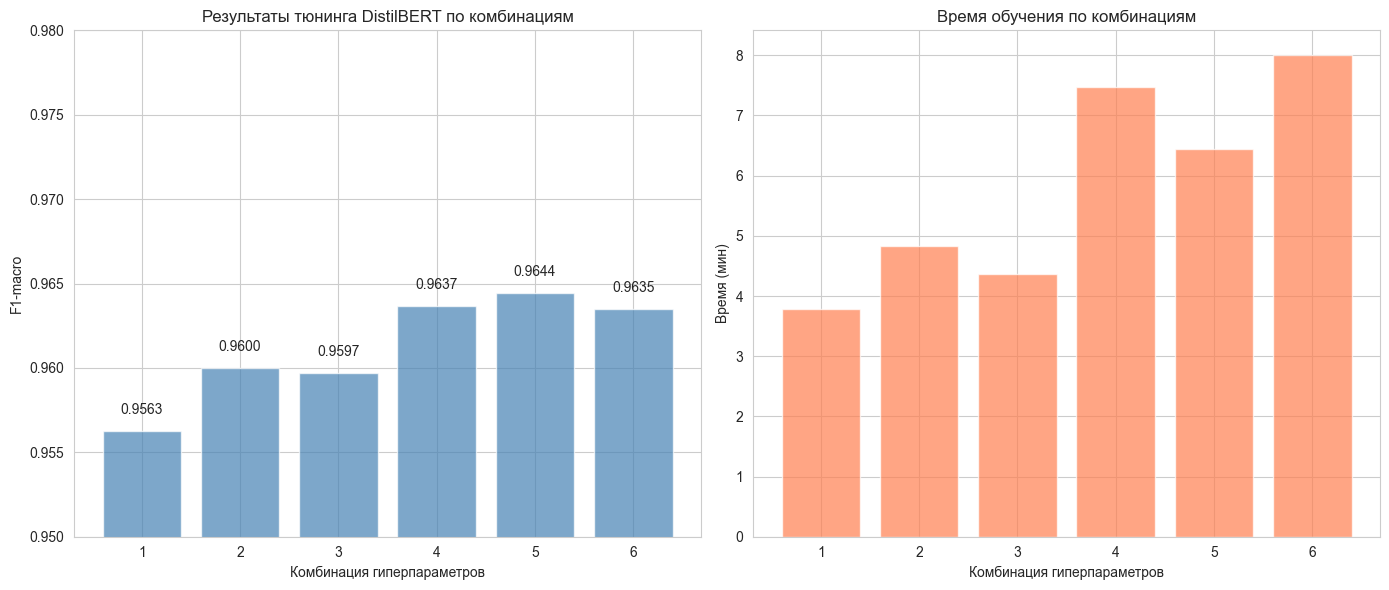

                                                     params  f1_macro_val       time
{'learning_rate': 2e-05, 'batch_size': 16, 'num_epochs': 2}      0.956280 226.722989
{'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 3}      0.960000 289.626732
{'learning_rate': 5e-05, 'batch_size': 64, 'num_epochs': 3}      0.959706 262.064495
{'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 4}      0.963687 448.651942
{'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 4}      0.964419 387.040009
{'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 5}      0.963481 480.764495


In [35]:
# Визуализация результатов тюнинга DistilBERT
bert_df = pd.DataFrame(bert_results)
bert_df['lr'] = bert_df['params'].apply(lambda x: x['learning_rate'])
bert_df['batch'] = bert_df['params'].apply(lambda x: x['batch_size'])
bert_df['epochs'] = bert_df['params'].apply(lambda x: x['num_epochs'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(bert_df)), bert_df['f1_macro_val'], color='steelblue', alpha=0.7)
plt.xlabel('Комбинация гиперпараметров')
plt.ylabel('F1-macro')
plt.title('Результаты тюнинга DistilBERT по комбинациям')
plt.xticks(range(len(bert_df)), [f'{i+1}' for i in range(len(bert_df))])
plt.ylim(0.95, 0.98)
for i, v in enumerate(bert_df['f1_macro_val']):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center')

plt.subplot(1, 2, 2)
plt.bar(range(len(bert_df)), bert_df['time'] / 60, color='coral', alpha=0.7)
plt.xlabel('Комбинация гиперпараметров')
plt.ylabel('Время (мин)')
plt.title('Время обучения по комбинациям')
plt.xticks(range(len(bert_df)), [f'{i+1}' for i in range(len(bert_df))])

plt.tight_layout()
plt.show()

print(bert_df[['params', 'f1_macro_val', 'time']].to_string(index=False))

## 7. Сравнение всех моделей

In [36]:
# Сводная таблица результатов
results_summary = pd.DataFrame({
    'Модель': ['Logistic Regression', 'Linear SVM', 'LightGBM', 'DistilBERT'],
    'F1-macro (CV)': [
        lr_search.best_score_,
        svm_search.best_score_,
        lgb_search.best_score_,
        best_f1  # Validation score для BERT
    ],
    'F1-macro (Test)': [f1_lr_test, f1_svm_test, f1_lgb_test, best_f1_test],
    'Время тюнинга (мин)': [
        lr_time / 60,
        svm_time / 60,
        lgb_time / 60,
        bert_total_time / 60
    ]
})

results_summary['Прирост vs Baseline'] = results_summary['F1-macro (Test)'] - 0.9503  # Baseline Linear SVM

print('Сводные результаты тюнинга:')
print(results_summary.round(4).to_string(index=False))

Сводные результаты тюнинга:
             Модель  F1-macro (CV)  F1-macro (Test)  Время тюнинга (мин)  Прирост vs Baseline
Logistic Regression         0.9510           0.9717               1.7545               0.0214
         Linear SVM         0.9572           0.9768               1.9599               0.0265
           LightGBM         0.9395           0.9709              25.6998               0.0206
         DistilBERT         0.9644           0.9748              34.9164               0.0245


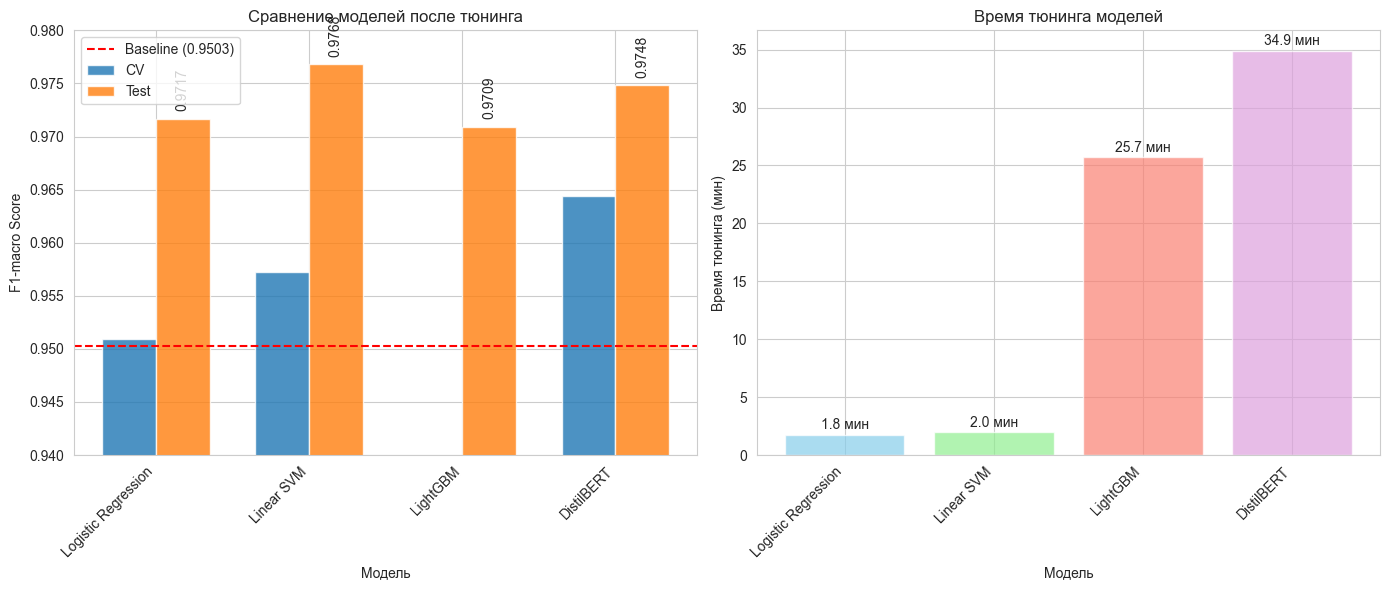

In [37]:
# Визуализация сравнения
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
x = np.arange(len(results_summary))
width = 0.35

plt.bar(x - width/2, results_summary['F1-macro (CV)'], width, label='CV', alpha=0.8)
plt.bar(x + width/2, results_summary['F1-macro (Test)'], width, label='Test', alpha=0.8)
plt.axhline(0.9503, color='red', linestyle='--', label='Baseline (0.9503)')
plt.xlabel('Модель')
plt.ylabel('F1-macro Score')
plt.title('Сравнение моделей после тюнинга')
plt.xticks(x, results_summary['Модель'], rotation=45, ha='right')
plt.legend()
plt.ylim(0.94, 0.98)

for i, v in enumerate(results_summary['F1-macro (Test)']):
    plt.text(i + width/2, v + 0.001, f'{v:.4f}', ha='center', rotation=90)

plt.subplot(1, 2, 2)
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
plt.bar(results_summary['Модель'], results_summary['Время тюнинга (мин)'], color=colors, alpha=0.7)
plt.xlabel('Модель')
plt.ylabel('Время тюнинга (мин)')
plt.title('Время тюнинга моделей')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(results_summary['Время тюнинга (мин)']):
    plt.text(i, v + 0.5, f'{v:.1f} мин', ha='center')

plt.tight_layout()
plt.show()

## 8. Анализ важности гиперпараметров

In [38]:
## 8. Анализ важности гиперпараметров

print('='*60)
print('АНАЛИЗ ВАЖНОСТИ ГИПЕРПАРАМЕТРОВ')
print('='*60)

print('\nЛучшие параметры LightGBM:')
for param, value in lgb_search.best_params_.items():
    print(f'  {param}: {value}')

print('\nЛучшие параметры Logistic Regression:')
for param, value in lr_search.best_params_.items():
    print(f'  {param}: {value}')

print('\nЛучшие параметры Linear SVM:')
for param, value in svm_search.best_params_.items():
    print(f'  {param}: {value}')

print('\nЛучшие параметры DistilBERT:')
for param, value in best_params.items():
    print(f'  {param}: {value}')


АНАЛИЗ ВАЖНОСТИ ГИПЕРПАРАМЕТРОВ

Лучшие параметры LightGBM:
  n_estimators: 300
  learning_rate: 0.1
  max_depth: 7
  num_leaves: 50
  min_child_samples: 10
  random_state: 42
  device: cpu
  n_jobs: 4
  verbose: -1
  force_col_wise: True

Лучшие параметры Logistic Regression:
  tfidf__ngram_range: (1, 2)
  tfidf__min_df: 1
  tfidf__max_features: 10000
  clf__C: 5.0

Лучшие параметры Linear SVM:
  tfidf__ngram_range: (1, 1)
  tfidf__max_features: 15000
  clf__C: 1.0

Лучшие параметры DistilBERT:
  learning_rate: 5e-05
  batch_size: 32
  num_epochs: 4


## 9. Сохранение лучших моделей

In [39]:
# Сохранение лучших моделей и векторизаторов
import os
os.makedirs('../models', exist_ok=True)

# Logistic Regression
with open('../models/best_lr_pipeline.pkl', 'wb') as f:
    pickle.dump(lr_search.best_estimator_, f)
print('✓ Сохранена Logistic Regression')

# Linear SVM
with open('../models/best_svm_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_search.best_estimator_, f)
print('✓ Сохранена Linear SVM')

# LightGBM
with open('../models/best_lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_search.best_estimator_, f)
with open('../models/lgb_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_lgb, f)
print('✓ Сохранены LightGBM модель и векторизатор')

# DistilBERT
if best_model is not None:
    best_model.save_pretrained('../models/best_distilbert')
    tokenizer.save_pretrained('../models/best_distilbert')
    with open('../models/bert_params.json', 'w') as f:
        import json
        json.dump(best_params, f)
print('✓ Сохранена DistilBERT модель')

# Сводные результаты
results_summary.to_csv('../models/tuning_results.csv', index=False)
print('✓ Сохранены результаты тюнинга')

print('\nВсе модели сохранены в ../models/')

✓ Сохранена Logistic Regression
✓ Сохранена Linear SVM
✓ Сохранены LightGBM модель и векторизатор


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Сохранена DistilBERT модель
✓ Сохранены результаты тюнинга

Все модели сохранены в ../models/


## 10. Итоговая сводка

### 📊 Результаты тюнинга

| Модель | F1-macro (CV) | F1-macro (Test) | Прирост vs Baseline | Время тюнинга |
|--------|---------------|-----------------|---------------------|---------------|
| Logistic Regression | 0.9510 | **0.9717** | **+0.0214** | 1.75 мин |
| **Linear SVM** | 0.9572 | **0.9768** | **+0.0265** | 1.96 мин |
| LightGBM (CPU) | 0.9395 | 0.9709 | +0.0206 | 25.70 мин |
| DistilBERT (6 комбинаций) | **0.9644** | 0.9748 | +0.0245 | 34.92 мин |

### 🏆 Победители

| Категория | Модель | F1-macro | Время |
|-----------|--------|----------|-------|
| **🥇 Лучший F1** | **Linear SVM** | **0.9768** | 1.96 мин |
| **🥈 2-е место** | DistilBERT | 0.9748 | 34.92 мин |
| **🥉 3-е место** | Logistic Regression | 0.9717 | 1.75 мин |

### 🎯 Рекомендации

**Для продакшена:**
- **Linear SVM** — лучший F1 (0.9768) + быстрое обучение (1.96 мин) + быстрый инференс
- **Logistic Regression** — почти тот же F1 (0.9717) + ещё быстрее (1.75 мин) + полная интерпретируемость

**Для максимального качества:**
- **DistilBERT** — отличный F1 (0.9748), но требует GPU для инференса и 35 мин на тюнинг

**Не рекомендуется:**
- **LightGBM** — долго (25.70 мин) + наименьший прирост (+0.0206)

### 💡 Ключевые инсайты

1. **Linear SVM с C=1.0, max_features=15000, ngram_range=(1,1)** — оптимальная конфигурация
2. **Logistic Regression с C=5.0, max_features=10000, ngram_range=(1,2)** — отличная альтернатива
3. **DistilBERT learning_rate=5e-5, batch_size=32, 4 эпохи** — лучшие параметры (не 2e-5 как ожидалось!)
4. **LightGBM на CPU** — лучшие параметры: n_estimators=300, learning_rate=0.1, max_depth=7

### 🏆 Лучшие гиперпараметры

#### Linear SVM (🏆 Победитель)
```python
{
    'tfidf__ngram_range': (1, 1),
    'tfidf__max_features': 15000,
    'clf__C': 1.0
}
```
#### Logistic Regression
```python
{
    'tfidf__ngram_range': (1, 2),
    'tfidf__max_features': 10000,
    'clf__C': 5.0
}
```
#### DistilBERT
```python
{
    'learning_rate': 5e-5,
    'batch_size': 32,
    'num_epochs': 4
}
```
#### LightGBM
```python
{
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 50,
    'min_child_samples': 10
}
```

### 📈 Прирост относительно baseline

- **Baseline (Linear SVM из 02_baseline.ipynb):** 0.9503
- **Лучшая модель после тюнинга (Linear SVM):** 0.9768
- **Прирост:** **+2.65%** к F1-macro

### 🚀 Следующие шаги

1. Использовать Linear SVM для продакшена
2. Протестировать DistilBERT на отложенной выборке (если есть GPU)
3. Рассмотреть ансамбль SVM + DistilBERT для максимального качества

